In [2]:
import os
import csv
from obspy import read
from datetime import datetime, timedelta
import time
import numpy as np

# Percorso principale delle stazioni
data_dir = "E:\data\sismico_infra"

# Lista delle stazioni
stations = ["ECPN", "ESLN", "EPDN", "ECNE", "AIO"]

# Intervallo temporale da coprire (dal 1 gennaio al 31 dicembre 2021)
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

# Funzione per verificare la copertura temporale di una stazione
def check_coverage_for_station(station_path, station_name, csv_writer):
    print(f"\nControllo della copertura temporale per la stazione: {station_name}\n")

    # Scorre attraverso tutte le componenti della stazione
    for component in os.listdir(station_path):
        component_path = os.path.join(station_path, component)

        # Verifica se la directory del componente esiste
        if os.path.isdir(component_path):
            print(f"Stazione: {station_name}, Componente: {component}")
            current_time = start_date
            try:
                # Legge i file della componente uno alla volta per ridurre il consumo di memoria
                for file in sorted(os.listdir(component_path)):
                    if file.endswith(tuple(f".{i:03d}" for i in range(1, 366))):
                        file_path = os.path.join(component_path, file)
                        try:
                            # Apre il file per verificare se contiene dati
                            if os.path.getsize(file_path) == 0:
                                print(f"Il file {file} è vuoto.")
                                continue

                            stream = read(file_path, format="MSEED", verbose=False, headonly=True)
                            time.sleep(0.1) 
                            if not stream:
                                print(f"Il file {file} non contiene dati utilizzabili.")
                                continue

                            # Controlla ogni traccia nel file
                            for tr in stream:
                                file_start = tr.stats.starttime.datetime
                                file_end = tr.stats.endtime.datetime

                                # Se c'è un gap significativo tra current_time e l'inizio del file, registra il gap
                                if current_time < file_start and (file_start - current_time).total_seconds() > 1:
                                    csv_writer.writerow([station_name, component, file, current_time.strftime("%Y-%m-%d %H:%M:%S"), file_start.strftime("%Y-%m-%d %H:%M:%S"), "N/A", "N/A"])
                                    print(f"Gap dal {current_time.strftime('%Y-%m-%d %H:%M:%S')} al {file_start.strftime('%Y-%m-%d %H:%M:%S')}")

                                # Aggiorna current_time al massimo dell'attuale endtime
                                current_time = max(current_time, file_end)
                        except Exception as e:
                            print(f"Errore durante la lettura del file {file} per la componente {component}: {e}")

                # Controlla se c'è un gap alla fine del periodo
                if current_time < end_date:
                    csv_writer.writerow([station_name, component, "N/A", current_time.strftime("%Y-%m-%d %H:%M:%S"), end_date.strftime("%Y-%m-%d %H:%M:%S"), "N/A", "N/A"])
                    print(f"Gap dal {current_time.strftime('%Y-%m-%d %H:%M:%S')} al {end_date.strftime('%Y-%m-%d %H:%M:%S')}")
                else:
                    print(f"Component: {component} - Nessun gap trovato")
            except MemoryError:
                print(f"Errore di memoria durante la lettura dei dati per la componente {component}: impossibile allocare la memoria necessaria.")
            except Exception as e:
                print(f"Errore durante la lettura dei dati per la componente {component}: {e}")

# Scorre tutte le stazioni, controlla la copertura temporale per ognuna e la salva in un file CSV
def main():
    with open("gaps_report.csv", mode="w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        # Scrive l'intestazione del file CSV
        csv_writer.writerow(["Stazione", "Componente", "File", "Starttime", "Endtime", "Gap(s)", "Duration(s)"])
        
        for station in stations:
            station_path = os.path.join(data_dir, station)
            if os.path.exists(station_path):
                check_coverage_for_station(station_path, station, csv_writer)
            else:
                print(f"Stazione {station} non trovata nel percorso specificato.")

if __name__ == "__main__":
    main()



Controllo della copertura temporale per la stazione: ECPN

Stazione: ECPN, Componente: HDO.D
Gap dal 2021-01-29 23:59:59 al 2021-01-31 00:00:00
Gap dal 2021-02-22 23:59:59 al 2021-02-24 00:00:00
Gap dal 2021-03-18 23:59:59 al 2021-03-20 00:00:00
Gap dal 2021-03-21 23:59:59 al 2021-03-24 23:59:55
Gap dal 2021-03-24 23:59:55 al 2021-03-25 00:00:00
Gap dal 2021-04-20 23:59:59 al 2021-04-22 00:00:00
Gap dal 2021-05-12 23:59:59 al 2021-05-14 00:00:00
Gap dal 2021-06-07 23:59:59 al 2021-06-09 00:00:00
Gap dal 2021-06-20 23:59:59 al 2021-06-22 00:00:00
Gap dal 2021-07-05 23:59:59 al 2021-07-08 00:00:00
Gap dal 2021-07-28 23:59:59 al 2021-07-30 00:00:00
Gap dal 2021-08-25 23:59:59 al 2021-08-27 00:00:00
Gap dal 2021-10-06 23:59:59 al 2021-10-08 00:00:00
Gap dal 2021-10-19 23:59:59 al 2021-10-21 00:00:00
Gap dal 2021-11-17 23:59:59 al 2021-11-19 00:00:00
Gap dal 2021-11-23 23:59:59 al 2021-11-25 00:00:00
Gap dal 2021-11-28 23:59:59 al 2021-12-31 00:00:00
Stazione: ECPN, Componente: HHE.D
Gap d

In [11]:
import numpy as np
import obspy
from obspy import read
import pywt
import scipy.stats
from scipy.signal import welch, butter, filtfilt
import glob
import os
import pickle
import gc
from joblib import Parallel, delayed
from scipy.signal import find_peaks
import pandas as pd

# Function to check if the signal is empty
def is_empty_signal(signal):
    return len(signal) == 0

# Function to apply a bandpass or lowpass filter
def bandpass_filter(signal, fs, lowcut=None, highcut=None, order=4):
    if is_empty_signal(signal):
        return np.array([np.nan])
    nyquist = 0.5 * fs
    if lowcut and highcut:
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
    elif lowcut:
        low = lowcut / nyquist
        b, a = butter(order, low, btype='high')
    elif highcut:
        high = highcut / nyquist
        b, a = butter(order, high, btype='low')
    else:
        return signal  # No filter applied
    return filtfilt(b, a, signal)

# Function for wavelet denoising
def wavelet_denoising(signal, wavelet='db4', level=4):
    if is_empty_signal(signal):
        return np.array([np.nan])
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-level])) / 0.6745  # Threshold based on MAD
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return pywt.waverec(denoised_coeffs, wavelet)

# Placeholder feature extraction functions
def signal_energy(signal):
    return np.sum(signal ** 2)

def signal_rms(signal):
    return np.sqrt(np.mean(signal ** 2))

def max_amplitude(signal):
    return np.max(np.abs(signal))

def power_spectrum(signal, fs, frequency_bands):
    freqs, psd = welch(signal, fs=fs)
    power_band_features = {}
    for band in frequency_bands:
        band_power = np.sum(psd[(freqs >= band[0]) & (freqs <= band[1])])
        power_band_features[f'band_{band[0]}_{band[1]}'] = band_power
    return power_band_features

def spectral_entropy(signal, fs):
    freqs, psd = welch(signal, fs=fs)
    psd_norm = psd / np.sum(psd)
    entropy = -np.sum(psd_norm * np.log2(psd_norm + np.finfo(float).eps))
    return entropy

def signal_statistics(signal):
    return {
        'std_dev': np.std(signal),
        'variance': np.var(signal),
        'skewness': scipy.stats.skew(signal),
        'kurtosis': scipy.stats.kurtosis(signal)
    }

def crest_factor(signal):
    return max_amplitude(signal) / (signal_rms(signal) + np.finfo(float).eps)

def wavelet_coefficients(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return [np.sum(np.abs(c)) for c in coeffs]

def signal_derivatives(signal):
    first_deriv = np.gradient(signal)
    second_deriv = np.gradient(first_deriv)
    return first_deriv, second_deriv

def peak_count(signal, threshold):
    peaks, _ = find_peaks(signal, height=threshold)
    return len(peaks)

def horizontal_to_vertical_ratio(east_signal, north_signal, vertical_signal):
    horizontal_magnitude = np.sqrt(east_signal**2 + north_signal**2)
    return np.mean(horizontal_magnitude) / (np.mean(np.abs(vertical_signal)) + np.finfo(float).eps)

def direction_of_motion(east_signal, north_signal):
    return np.arctan2(np.mean(north_signal), np.mean(east_signal))

def rolling_snr(signal, window_size=10):
    signal_series = pd.Series(signal)
    rolling_mean = signal_series.rolling(window=window_size, min_periods=1).mean()
    rolling_std = signal_series.rolling(window=window_size, min_periods=1).std()
    rolling_std.replace(0, 1e-6, inplace=True)  # Increase epsilon to avoid numerical issues
    rolling_snr = 10 * np.log10((rolling_mean**2) / (rolling_std**2))
    rolling_snr = rolling_snr.replace([np.inf, -np.inf], np.nan)
    rolling_snr = rolling_snr.bfill()  # Backfill to handle initial NaN values
    rolling_snr = rolling_snr.ffill()  # Forward fill as a fallback
    return rolling_snr

# Load data from all stations and components (excluding infrasound)
components = ['HHZ.D', 'HHE.D', 'HHN.D']
frequency_bands = [(0.5, 1), (1, 5), (5, 10)]

# Define a complete timeline from January 1, 2021 to December 31, 2021 with a 1-minute sampling rate
start_time = pd.Timestamp('2021-01-01 00:00:00')
end_time = pd.Timestamp('2021-12-31 23:59:00')
timeline = pd.date_range(start=start_time, end=end_time, freq='min')

# Iterate through all stations and components
stations = glob.glob("E:\data\sismico_infra\*")
total_stations = len(stations)
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

for station_idx, station in enumerate(stations):
    current_station = os.path.basename(station)  # Store current station name for debugging
    print(f"Processing station {station_idx + 1}/{total_stations}: {station}")
    hhe_paths = sorted(glob.glob(os.path.join(station, 'HHE.D', '*')))
    hhn_paths = sorted(glob.glob(os.path.join(station, 'HHN.D', '*')))
    hhz_paths = sorted(glob.glob(os.path.join(station, 'HHZ.D', '*')))

    station_features_df = pd.DataFrame(index=timeline)  # DataFrame to save features of the current station with complete timeline

    # Debug: Log if no files are found
    if not hhe_paths:
        print(f"No HHE files found for station {station} in the specified date range.")
    if not hhn_paths:
        print(f"No HHN files found for station {station} in the specified date range.")
    if not hhz_paths:
        print(f"No HHZ files found for station {station} in the specified date range.")

    total_files = len(hhe_paths)
    for file_idx, (hhe_path, hhn_path, hhz_path) in enumerate(zip(hhe_paths, hhn_paths, hhz_paths)):
        print(f"  Processing file {file_idx + 1}/{total_files} for station {station}")
        if os.path.isfile(hhe_path) and os.path.isfile(hhn_path) and os.path.isfile(hhz_path):
            st_e = read(hhe_path, format='MSEED')
            st_n = read(hhn_path, format='MSEED')
            st_z = read(hhz_path, format='MSEED')

            # Debug: Verify data loading
            print(f"    Debug: Loaded {hhe_path} with {len(st_e[0].data)} samples.")
            print(f"    Debug: Loaded {hhn_path} with {len(st_n[0].data)} samples.")
            print(f"    Debug: Loaded {hhz_path} with {len(st_z[0].data)} samples.")

            fs = st_z[0].stats.sampling_rate
            window_length = max(int(fs * 60), 1)  # Window length of 1 minute in samples

            def process_window(tr_e, tr_n, tr_z, start_idx, window_length, fs, current_station):
                try:
                    end_idx = start_idx + window_length
                    if end_idx > len(tr_z.data):
                        end_idx = len(tr_z.data)
                    east_signal = np.array(tr_e.data[start_idx:end_idx])
                    north_signal = np.array(tr_n.data[start_idx:end_idx])
                    vertical_signal = np.array(tr_z.data[start_idx:end_idx])

                    if is_empty_signal(vertical_signal):
                        print(f"Empty vertical signal for station {current_station}, start index {start_idx}")
                        return None

                    # Apply bandpass filter and wavelet denoising
                    east_signal = bandpass_filter(east_signal, fs, lowcut=0.5, highcut=10)
                    north_signal = bandpass_filter(north_signal, fs, lowcut=0.5, highcut=10)
                    vertical_signal = bandpass_filter(vertical_signal, fs, lowcut=0.5, highcut=10)

                    east_signal = wavelet_denoising(east_signal)
                    east_signal = pd.Series(east_signal).rolling(window=10, min_periods=1).mean().to_numpy()
                    north_signal = wavelet_denoising(north_signal)
                    north_signal = pd.Series(north_signal).rolling(window=10, min_periods=1).mean().to_numpy()
                    vertical_signal = wavelet_denoising(vertical_signal)

                    # Apply rolling mean (moving average) for smoothing the signal
                    vertical_signal = pd.Series(vertical_signal).rolling(window=10, min_periods=1).mean().to_numpy()

                    # Feature extraction
                    energy = signal_energy(vertical_signal)
                    rms = signal_rms(vertical_signal)
                    max_amp = max_amplitude(vertical_signal)
                    power_band_features = power_spectrum(vertical_signal, fs, frequency_bands)
                    entropy = spectral_entropy(vertical_signal, fs)
                    statistics = signal_statistics(vertical_signal)
                    crest = crest_factor(vertical_signal)
                    wavelet_feats = wavelet_coefficients(vertical_signal)
                    first_deriv, second_deriv = signal_derivatives(vertical_signal)
                    peak_counts = peak_count(vertical_signal, threshold=0.8 * max_amp)
                    h_v_ratio = horizontal_to_vertical_ratio(east_signal, north_signal, vertical_signal)
                    motion_direction = direction_of_motion(east_signal, north_signal)
                    snr = rolling_snr(vertical_signal, window_size=10)

                    feature = {
                        'energy': float(energy) if not np.isnan(energy) else np.nan,
                        'rms': float(rms) if not np.isnan(rms) else np.nan,
                        'max_amplitude': float(max_amp) if not np.isnan(max_amp) else np.nan,
                        'power_band_features': power_band_features,
                        'spectral_entropy': entropy,
                        'statistics_std_dev': statistics['std_dev'],
                        'statistics_variance': statistics['variance'],
                        'statistics_skewness': statistics['skewness'],
                        'statistics_kurtosis': statistics['kurtosis'],
                        'crest_factor': float(crest) if not np.isnan(crest) else np.nan,
                        'wavelet_coefficients': wavelet_feats,
                        'peak_count': peak_counts,
                        'horizontal_to_vertical_ratio': float(h_v_ratio) if not np.isnan(h_v_ratio) else np.nan,
                        'motion_direction': float(motion_direction) if not np.isnan(motion_direction) else np.nan,
                        'rolling_snr': snr.mean() if isinstance(snr, pd.Series) and not snr.isna().all() else np.nan
                    }
                    return feature
                except Exception as e:
                    print(f"Error processing window for station {current_station}, start index {start_idx}: {e}")
                    return None

            results = Parallel(n_jobs=-1, backend='loky')(
                delayed(process_window)(tr_e, tr_n, tr_z, start_idx, window_length, fs, current_station)
                for tr_e, tr_n, tr_z in zip(st_e, st_n, st_z)
                for start_idx in range(0, len(tr_z.data), window_length)
            )

            features = [res for res in results if res is not None]

            # Debug: Check if features contain null values or valid data
            if features:
                null_count = pd.DataFrame(features).isnull().sum().sum()
                if null_count > 0:
                    print(f"    Debug: File {file_idx + 1}/{total_files} contains {null_count} null values in the extracted features.")
                else:
                    print(f"    Debug: File {file_idx + 1}/{total_files} contains valid extracted features with no null values.")
            else:
                print(f"    Debug: No features were extracted for file {file_idx + 1}/{total_files}.")

            if features:
                features_df = pd.DataFrame(features)
                day_start_time = pd.Timestamp(st_z[0].stats.starttime.datetime)
                features_df.index = pd.date_range(start=day_start_time, periods=len(features), freq='min')
                station_features_df = pd.concat([station_features_df, features_df]).groupby(level=0).first()
            else:
                print(f"Warning: No features were extracted for station {station}, file {file_idx + 1}. The DataFrame is empty.")

            # Memory cleanup
            gc.collect()

    # Save features to a pickle file for each station
    station_name = current_station
    station_features_df.to_pickle(os.path.join(output_dir, f'{station_name}_features.pkl'))

    # Debug: Verify if all data has been inserted
    non_empty_rows = station_features_df.dropna(how='all').shape[0]
    print(f"Completed processing station {station}. Total non-empty rows in DataFrame: {non_empty_rows}/{len(station_features_df)}")

print("Feature extraction completed and saved to individual station files")



Processing station 1/5: E:\data\sismico_infra\AIO
  Processing file 1/339 for station E:\data\sismico_infra\AIO
    Debug: Loaded E:\data\sismico_infra\AIO\HHE.D\IT.AIO..HHE.D.2021.001 with 8640000 samples.
    Debug: Loaded E:\data\sismico_infra\AIO\HHN.D\IT.AIO..HHN.D.2021.001 with 8640000 samples.
    Debug: Loaded E:\data\sismico_infra\AIO\HHZ.D\IT.AIO..HHZ.D.2021.001 with 8640000 samples.
    Debug: File 1/339 contains valid extracted features with no null values.
  Processing file 2/339 for station E:\data\sismico_infra\AIO
    Debug: Loaded E:\data\sismico_infra\AIO\HHE.D\IT.AIO..HHE.D.2021.002 with 8640000 samples.
    Debug: Loaded E:\data\sismico_infra\AIO\HHN.D\IT.AIO..HHN.D.2021.002 with 8640000 samples.
    Debug: Loaded E:\data\sismico_infra\AIO\HHZ.D\IT.AIO..HHZ.D.2021.002 with 8640000 samples.
    Debug: File 2/339 contains valid extracted features with no null values.
  Processing file 3/339 for station E:\data\sismico_infra\AIO
    Debug: Loaded E:\data\sismico_infra\

In [13]:
import pandas as pd
import pickle

# Path to imputed pickle files
imputed_station_files = {
    'AIO': 'output/AIO_features.pkl',
    'ECNE': 'output/ECNE_features.pkl',
    'ECPN': 'output/ECPN_features.pkl',
    'EPDN': 'output/EPDN_features.pkl',
    'ESLN': 'output/ESLN_features.pkl'
}

# Loading imputed data
imputed_dataframes = {}
for station, file_path in imputed_station_files.items():
    with open(file_path, 'rb') as file:
        imputed_dataframes[station] = pickle.load(file)

# Display summary of missing values for each station
for station, df in imputed_dataframes.items():
    print(f"Summary of missing values for {station}:")
    print(df.isna().sum())
    print("\n")

for station, df in imputed_dataframes.items():
    print(f"First 5 rows for {station}")
    print(df.head())
    print("\n")

Summary of missing values for AIO:
energy                          40258
rms                             40258
max_amplitude                   40258
power_band_features             37440
spectral_entropy                40258
statistics_std_dev              40258
statistics_variance             40258
statistics_skewness             40258
statistics_kurtosis             40258
crest_factor                    40258
wavelet_coefficients            37440
peak_count                      37440
horizontal_to_vertical_ratio    40258
motion_direction                40257
rolling_snr                     40258
dtype: int64


Summary of missing values for ECNE:
energy                          20619
rms                             20619
max_amplitude                   20619
power_band_features             14400
spectral_entropy                20619
statistics_std_dev              20619
statistics_variance             20619
statistics_skewness             20619
statistics_kurtosis             20619
cr

In [14]:
import os
import pandas as pd
import pickle
from obspy.core.utcdatetime import UTCDateTime

# Funzione per convertire UTCDateTime in datetime
def convert_timestamp(timestamp):
    if isinstance(timestamp, UTCDateTime):
        return timestamp.datetime
    return timestamp

# Percorso ai file delle stazioni
file_paths = ['output/AIO_features.pkl', 'output/ECNE_features.pkl', 'output/ECPN_features.pkl', 'output/EPDN_features.pkl', 'output/ESLN_features.pkl']

# Itera attraverso ogni file delle stazioni
for file_path in file_paths:
    # Ottieni il nome della stazione dal percorso del file
    station_name = os.path.basename(file_path).split('_')[0]

    # Carica il DataFrame dal file .pkl
    with open(file_path, 'rb') as file:
        df = pickle.load(file)

    # Verifica se l'indice contiene timestamp
    if isinstance(df.index, pd.DatetimeIndex):
        df.index = df.index.map(convert_timestamp)
        df.index = pd.to_datetime(df.index)
    else:
        print(f"Il file {file_path} non ha un indice di tipo timestamp.")
        continue

    # Crea una cartella per la stazione se non esiste
    percorso_cartella = os.path.join('output/', station_name)
    os.makedirs(percorso_cartella, exist_ok=True)

    # Salva ogni feature come un file .pkl separato, usando il timestamp come indice
    for colonna in df.columns:
        # Include solo la feature corrente
        df_feature = df[[colonna]]
        df_feature.index.name = 'timestamp'

        # Definisci il percorso di output per il file
        nome_file = f"{colonna}.pkl"
        percorso_file = os.path.join(percorso_cartella, nome_file)

        # Salva il DataFrame della feature corrente
        with open(percorso_file, 'wb') as output_file:
            pickle.dump(df_feature, output_file)

        print(f"Salvato {percorso_file} con {len(df_feature)} righe")




Salvato output/AIO\energy.pkl con 525600 righe
Salvato output/AIO\rms.pkl con 525600 righe
Salvato output/AIO\max_amplitude.pkl con 525600 righe
Salvato output/AIO\power_band_features.pkl con 525600 righe
Salvato output/AIO\spectral_entropy.pkl con 525600 righe
Salvato output/AIO\statistics_std_dev.pkl con 525600 righe
Salvato output/AIO\statistics_variance.pkl con 525600 righe
Salvato output/AIO\statistics_skewness.pkl con 525600 righe
Salvato output/AIO\statistics_kurtosis.pkl con 525600 righe
Salvato output/AIO\crest_factor.pkl con 525600 righe
Salvato output/AIO\wavelet_coefficients.pkl con 525600 righe
Salvato output/AIO\peak_count.pkl con 525600 righe
Salvato output/AIO\horizontal_to_vertical_ratio.pkl con 525600 righe
Salvato output/AIO\motion_direction.pkl con 525600 righe
Salvato output/AIO\rolling_snr.pkl con 525600 righe
Salvato output/ECNE\energy.pkl con 525600 righe
Salvato output/ECNE\rms.pkl con 525600 righe
Salvato output/ECNE\max_amplitude.pkl con 525600 righe
Salvato 

In [15]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
import os
import time

# Coordinate delle stazioni reali (latitudine, longitudine)
station_coords = {
    'AIO': (37.9713, 15.2330),
    'ECNE': (37.7653, 15.0018),
    'ECPN': (37.7437, 14.9865),
    'EPDN': (37.7659, 15.0168),
    'ESLN': (37.6934, 14.9744),
}

# Percorso delle cartelle delle stazioni
station_dirs = {
    'AIO': 'output/AIO',
    'ECNE': 'output/ECNE',
    'ECPN': 'output/ECPN',
    'EPDN': 'output/EPDN',
    'ESLN': 'output/ESLN'
}

# Lista delle feature da elaborare
features = ['crest_factor', 'energy', 'horizontal_to_vertical_ratio', 'max_amplitude', 'motion_direction',
            'peak_count', 'rms', 'rolling_snr', 'spectral_entropy',
            'statistics_kurtosis', 'statistics_skewness', 'statistics_std_dev', 'statistics_variance']

# Calcola la matrice dei pesi in base alla distanza tra le stazioni
station_names = list(station_dirs.keys())
coords = np.radians([station_coords[station] for station in station_names])
distance_matrix = haversine_distances(coords, coords) * 6371  # Convert to kilometers and multiply by Earth's radius
np.fill_diagonal(distance_matrix, np.inf)  # Set self-distances to infinity to avoid division by zero
weight_matrix = 1 / distance_matrix

# Carica i dati di una singola feature per tutte le stazioni
def load_feature_data(feature_name, station_dirs):
    feature_data = {}
    for station, station_dir in station_dirs.items():
        feature_file = os.path.join(station_dir, f'{feature_name}.pkl')
        with open(feature_file, 'rb') as f:
            data = pickle.load(f)
            if isinstance(data.index, pd.DatetimeIndex):
                data.index = pd.to_datetime(data.index)
            feature_data[station] = data
    return feature_data

# Imputazione dei dati mancanti utilizzando una media mobile ponderata dalle distanze
def weighted_moving_average_imputation(station_dirs, station_names, features, weight_matrix, window_size=3):
    print("Caricamento dei timestamp in corso...")
    time.sleep(0.5)  # Ritardo per visibilità del caricamento
    timestamp_data = {station: pd.read_pickle(os.path.join(station_dir, f'{features[0]}.pkl')).index for station, station_dir in station_dirs.items()}
    all_timestamps = pd.Index(sorted(set().union(*timestamp_data.values())))
    print("Timestamp caricati con successo.")

    for feature in features:
        print(f"Caricamento della feature '{feature}' in corso...")
        time.sleep(0.5)  # Ritardo per visibilità del caricamento
        station_data = load_feature_data(feature, station_dirs)
        print(f"Feature '{feature}' caricata con successo.")

        # Allinea i timestamp per tutte le stazioni
        for station in station_names:
            station_data[station] = station_data[station].reindex(all_timestamps).fillna(np.nan)

        print(f"Inizio imputazione per la feature '{feature}'...")
        time.sleep(0.5)  # Ritardo per visibilità dello stato di avanzamento
        all_data = pd.concat(station_data, axis=1)
        all_data.columns = station_names

        # Imputazione dei dati mancanti utilizzando la media mobile ponderata dalle distanze
        for i in range(window_size, len(all_data)):
            if all_data.iloc[i].isna().any():
                for station in station_names:
                    if pd.isna(all_data.at[all_data.index[i], station]):
                        weighted_sum = 0
                        weight_total = 0
                        for j in range(1, window_size + 1):
                            if not pd.isna(all_data.iloc[i - j][station]):
                                weights = weight_matrix[station_names.index(station)]
                                weighted_sum += weights @ all_data.iloc[i - j].fillna(0)
                                weight_total += np.sum(weights)

                        if weight_total > 0:
                            all_data.at[all_data.index[i], station] = weighted_sum / weight_total

        print(f"Imputazione per la feature '{feature}' completata.")

        # Salva i dati imputati per la feature corrente per tutte le stazioni
        for station in station_names:
            output_dir = os.path.join(station_dirs[station] + '_imputed')
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, f'{feature}_imputed.pkl')
            with open(output_file, 'wb') as f:
                pickle.dump(all_data[station], f)
            print(f"Feature '{feature}' per la stazione '{station}' salvata con successo. Numero di valori non nulli: {all_data[station].notna().sum()}.")

# Applica l'imputazione ai dati delle stazioni
weighted_moving_average_imputation(station_dirs, station_names, features, weight_matrix)




Caricamento dei timestamp in corso...
Timestamp caricati con successo.
Caricamento della feature 'crest_factor' in corso...
Feature 'crest_factor' caricata con successo.
Inizio imputazione per la feature 'crest_factor'...
Imputazione per la feature 'crest_factor' completata.
Feature 'crest_factor' per la stazione 'AIO' salvata con successo. Numero di valori non nulli: 525600.
Feature 'crest_factor' per la stazione 'ECNE' salvata con successo. Numero di valori non nulli: 525600.
Feature 'crest_factor' per la stazione 'ECPN' salvata con successo. Numero di valori non nulli: 525600.
Feature 'crest_factor' per la stazione 'EPDN' salvata con successo. Numero di valori non nulli: 525600.
Feature 'crest_factor' per la stazione 'ESLN' salvata con successo. Numero di valori non nulli: 525600.
Caricamento della feature 'energy' in corso...
Feature 'energy' caricata con successo.
Inizio imputazione per la feature 'energy'...
Imputazione per la feature 'energy' completata.
Feature 'energy' per la 

Caricamento e plot della feature 'crest_factor' in corso...


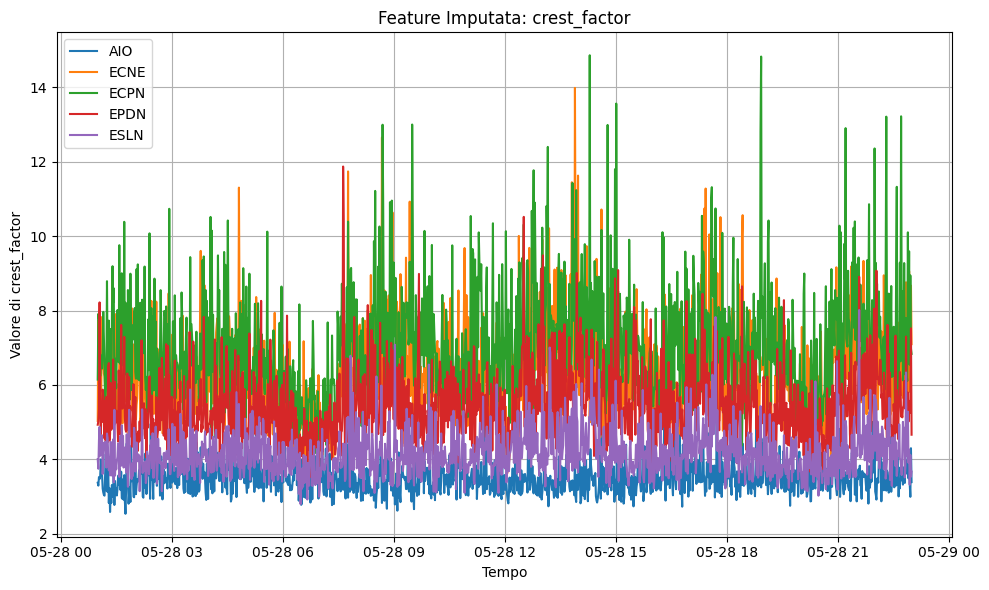

Caricamento e plot della feature 'energy' in corso...


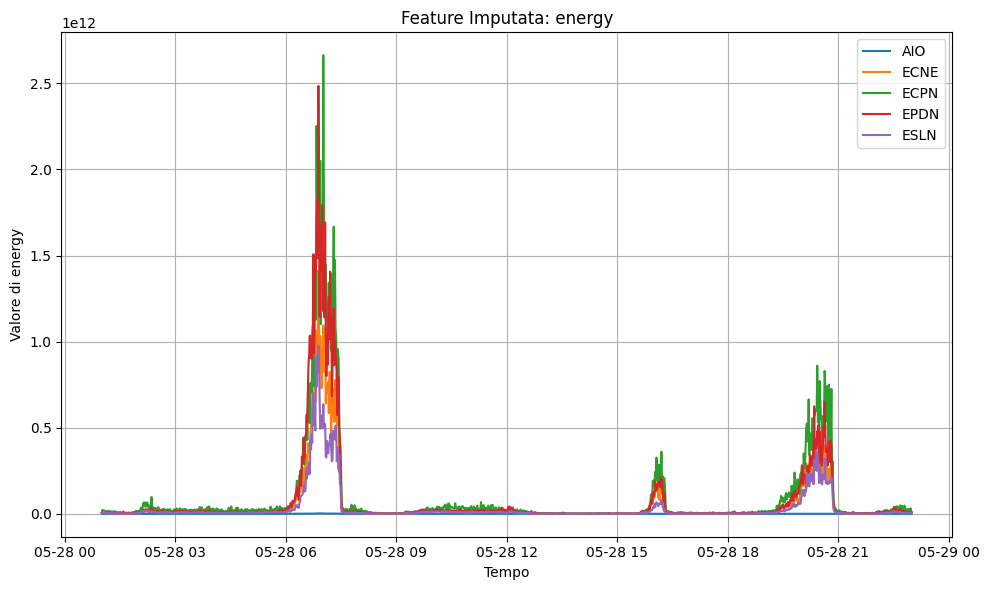

Caricamento e plot della feature 'horizontal_to_vertical_ratio' in corso...


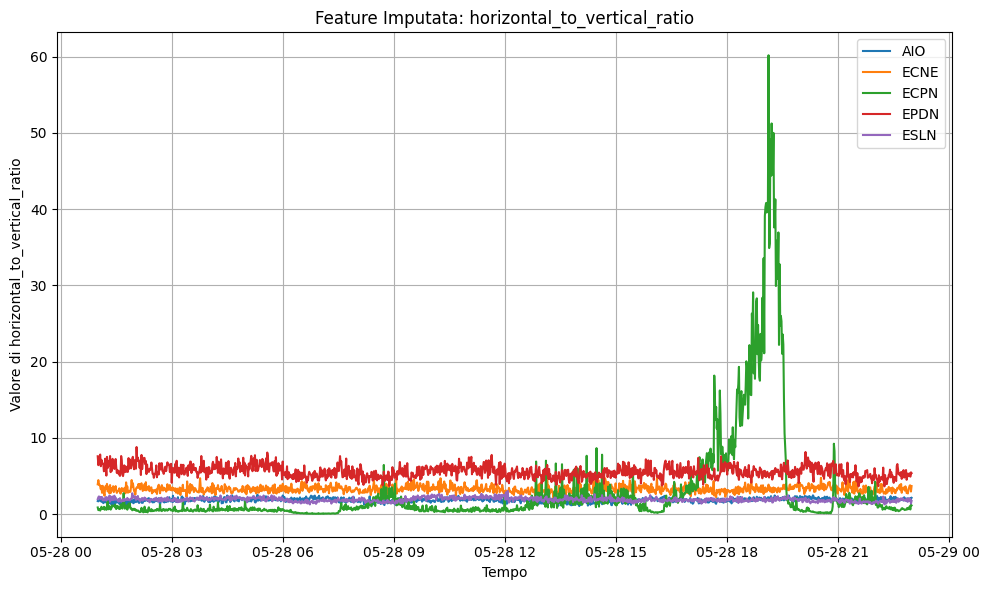

Caricamento e plot della feature 'max_amplitude' in corso...


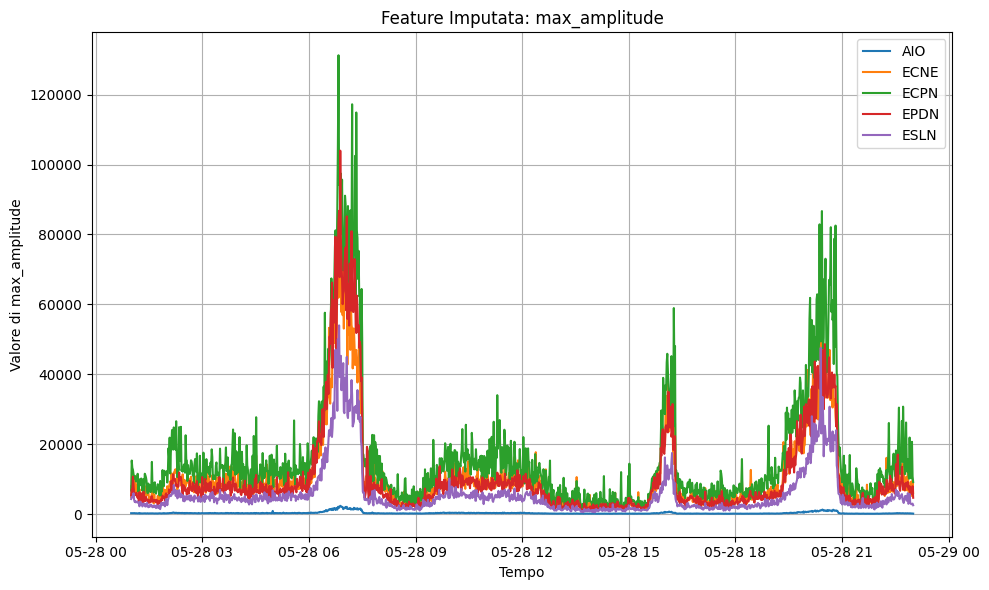

Caricamento e plot della feature 'motion_direction' in corso...


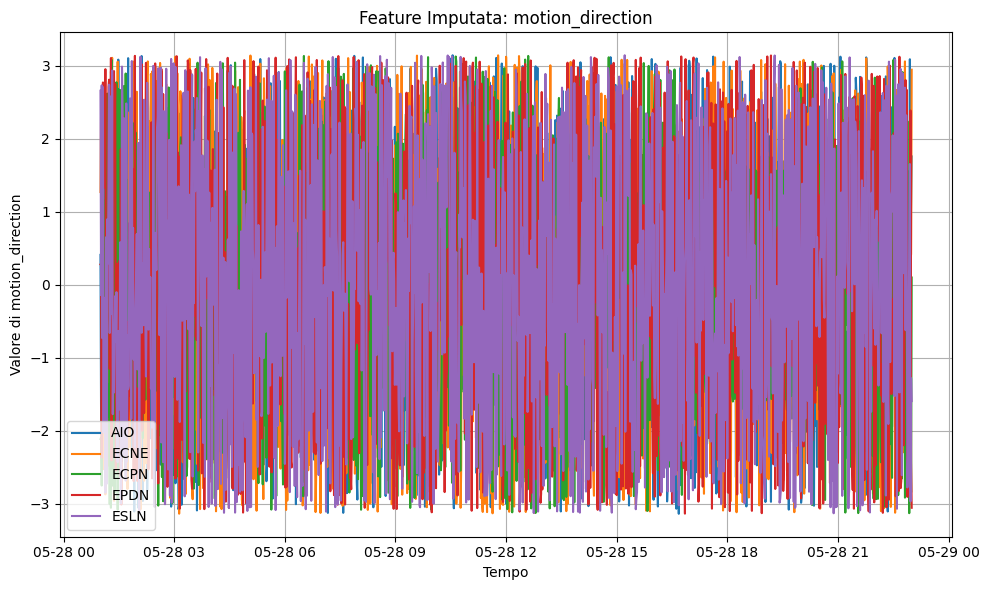

Caricamento e plot della feature 'peak_count' in corso...


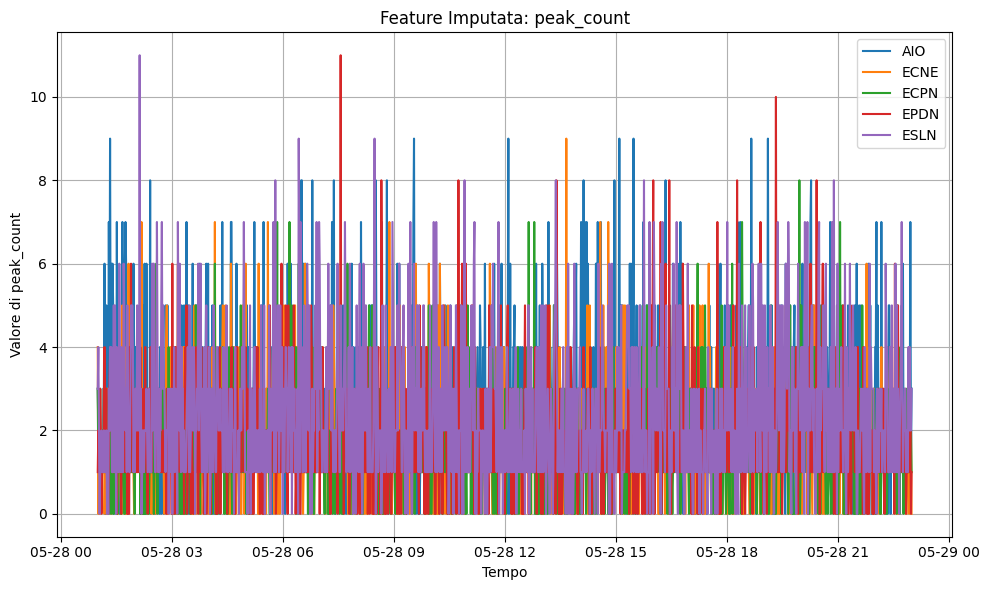

Caricamento e plot della feature 'rms' in corso...


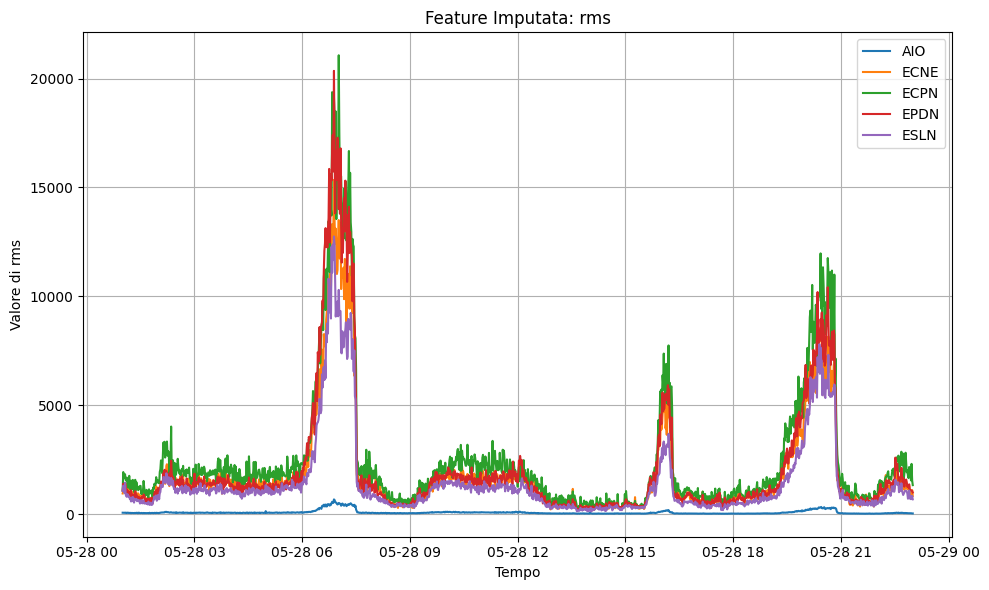

Caricamento e plot della feature 'rolling_snr' in corso...


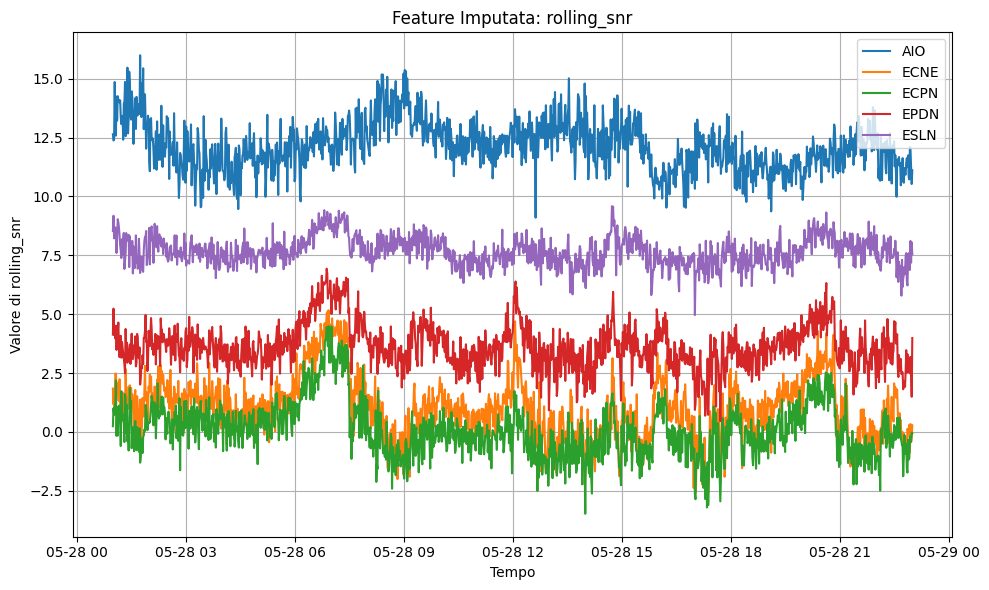

Caricamento e plot della feature 'spectral_entropy' in corso...


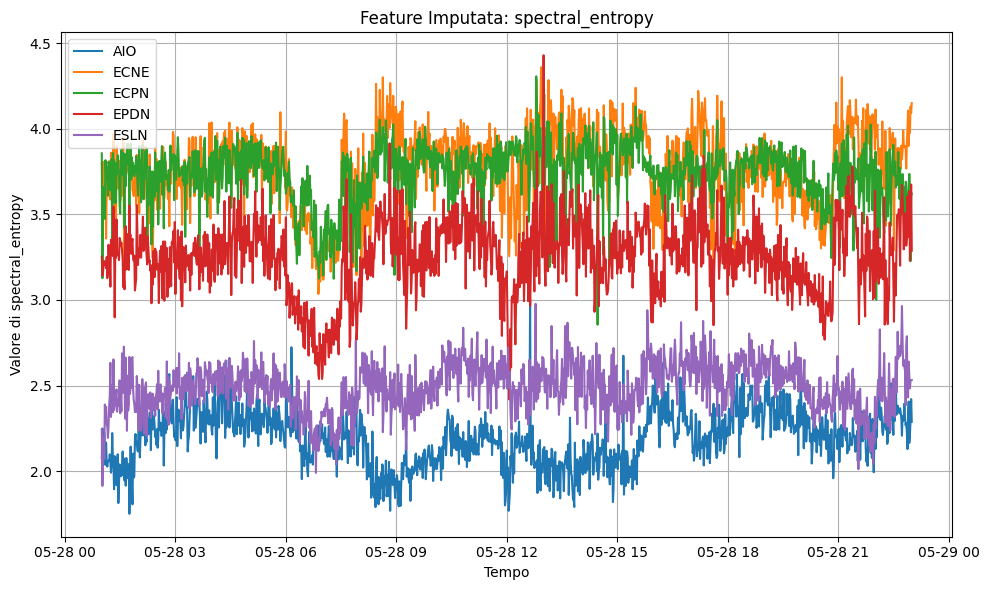

Caricamento e plot della feature 'statistics_kurtosis' in corso...


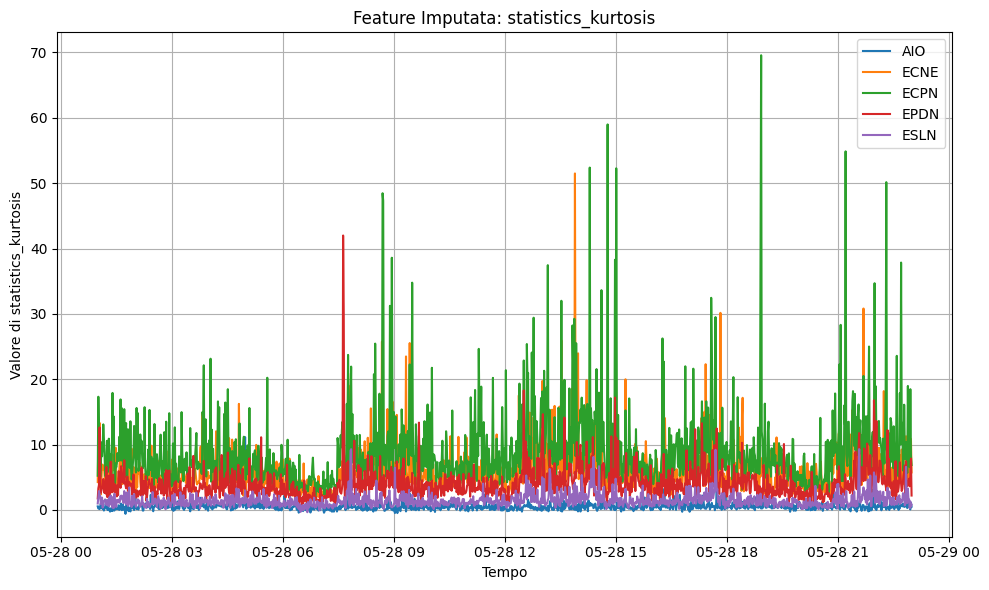

Caricamento e plot della feature 'statistics_skewness' in corso...


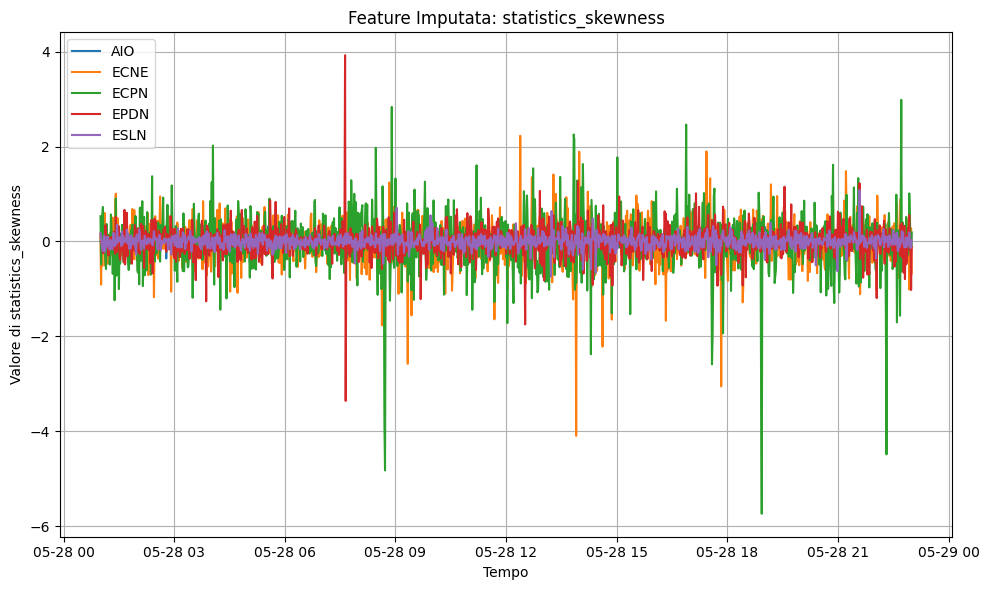

Caricamento e plot della feature 'statistics_std_dev' in corso...


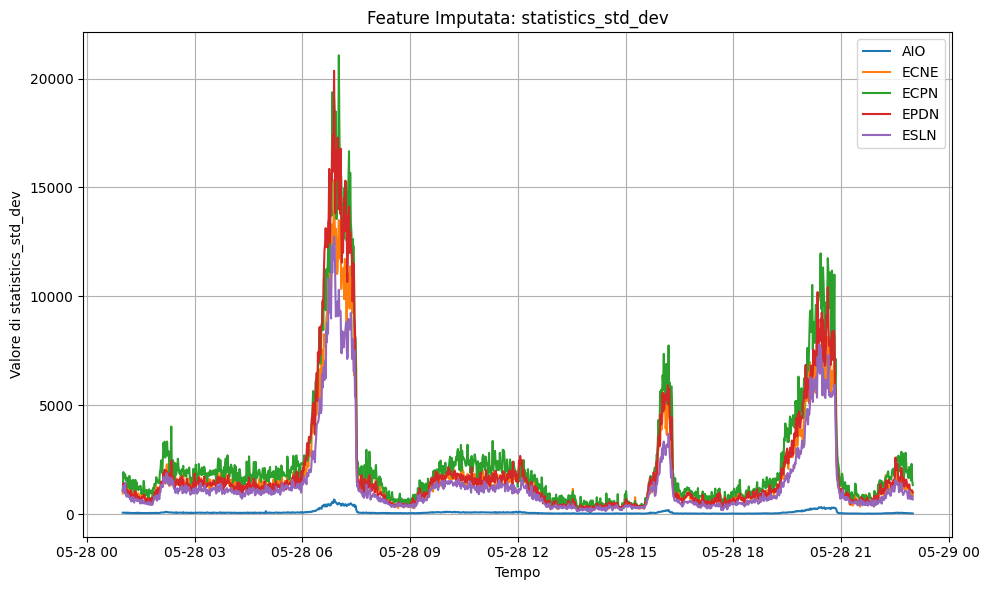

Caricamento e plot della feature 'statistics_variance' in corso...


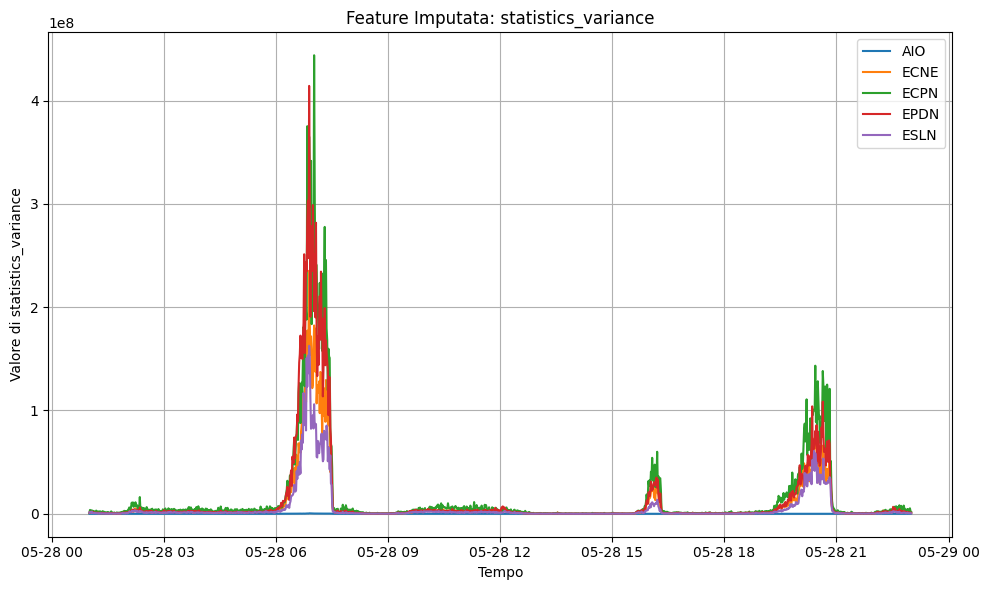

In [16]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os

# Coordinate delle stazioni reali (latitudine, longitudine)
station_dirs = {
    'AIO': 'output/AIO_imputed',
    'ECNE': 'output/ECNE_imputed',
    'ECPN': 'output/ECPN_imputed',
    'EPDN': 'output/EPDN_imputed',
    'ESLN': 'output/ESLN_imputed'
}

# Lista delle feature da elaborare
features = ['crest_factor', 'energy', 'horizontal_to_vertical_ratio', 'max_amplitude', 'motion_direction',
            'peak_count', 'rms', 'rolling_snr', 'spectral_entropy',
            'statistics_kurtosis', 'statistics_skewness', 'statistics_std_dev', 'statistics_variance']

# Funzione per caricare i dati imputati
def load_imputed_feature_data(feature_name, station_dirs):
    feature_data = {}
    for station, station_dir in station_dirs.items():
        feature_file = os.path.join(station_dir, f'{feature_name}_imputed.pkl')
        with open(feature_file, 'rb') as f:
            data = pickle.load(f)
            feature_data[station] = data
    return feature_data

# Funzione per plottare i dati in un arco temporale specifico
def plot_imputed_features(features, station_dirs, start_time=None, end_time=None):
    for feature in features:
        print(f"Caricamento e plot della feature '{feature}' in corso...")
        feature_data = load_imputed_feature_data(feature, station_dirs)
        plt.figure(figsize=(10, 6))

        for station, data in feature_data.items():
            if start_time and end_time:
                data = data[(data.index >= start_time) & (data.index <= end_time)]
            plt.plot(data.index, data.values, label=station)

        plt.title(f"Feature Imputata: {feature}")
        plt.xlabel("Tempo")
        plt.ylabel(f"Valore di {feature}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Plottaggio dei dati imputati in un arco temporale specificato
tempo_inizio = '2021-5-28 1:00:00'
tempo_fine = '2021-5-28 23:00:00'
plot_imputed_features(features, station_dirs, start_time=tempo_inizio, end_time=tempo_fine)


In [17]:
import os
import pandas as pd
import numpy as np

# Directory base contenente le cartelle delle stazioni
base_path = 'Data/final/'
station_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Controllo dei file per NaN e valori infiniti
for station in station_folders:
    station_path = os.path.join(base_path, station)
    feature_files = [f for f in os.listdir(station_path) if f.endswith('.pkl')]
    
    print(f"\n[INFO] Controllo dei file per la stazione: {station}")
    for file in feature_files:
        file_path = os.path.join(station_path, file)
        df = pd.read_pickle(file_path)
        
        # Controlla se ci sono valori NaN o infiniti
        nan_count = df.isna().sum().sum()
        inf_count = np.isinf(df.values).sum()
        
        if nan_count > 0 or inf_count > 0:
            print(f"File: {file}")
            if nan_count > 0:
                print(f"  - Valori NaN trovati: {nan_count}")
            if inf_count > 0:
                print(f"  - Valori infiniti trovati: {inf_count}")
        else:
            print(f"File: {file} - Nessun valore NaN o infinito trovato.")



[INFO] Controllo dei file per la stazione: AIO_imputed
File: crest_factor_imputed.pkl - Nessun valore NaN o infinito trovato.
File: energy_imputed.pkl - Nessun valore NaN o infinito trovato.
File: horizontal_to_vertical_ratio_imputed.pkl - Nessun valore NaN o infinito trovato.
File: max_amplitude_imputed.pkl - Nessun valore NaN o infinito trovato.
File: motion_direction_imputed.pkl - Nessun valore NaN o infinito trovato.
File: peak_count_imputed.pkl - Nessun valore NaN o infinito trovato.
File: rms_imputed.pkl - Nessun valore NaN o infinito trovato.
File: rolling_snr_imputed.pkl
  - Valori NaN trovati: 40258
  - Valori infiniti trovati: 3980
File: spectral_entropy_imputed.pkl - Nessun valore NaN o infinito trovato.
File: statistics_kurtosis_imputed.pkl - Nessun valore NaN o infinito trovato.
File: statistics_skewness_imputed.pkl - Nessun valore NaN o infinito trovato.
File: statistics_std_dev_imputed.pkl - Nessun valore NaN o infinito trovato.
File: statistics_variance_imputed.pkl - N